In [8]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import random
import math
import os, sys
from PIL import Image
from tqdm import tqdm
import time

In [9]:
image_dir = "/mnt/analysis/e21072/h5test/run_0277/len90_ic600000_pads21_eps5_samps5_poly2/773941CUT_Date_01_18_2024/"
sorted_dir = "/mnt/analysis/e17023/Adam/peakFinder/"

In [10]:
def get_track(image):
    # extract padplane from image
    padplane_bounds = ((3,40),(148,185))
    padplane = image[padplane_bounds[0][0]:padplane_bounds[1][0], padplane_bounds[0][1]:padplane_bounds[1][1], :]
    
    # extract track from padplane
    track = padplane[:,:,0].copy() # copy red channel for track
    track[track == 255] = 0 # set white to black
    track_bounds = np.where(track != 0) # get track bounds
    track_bounds = ((min(track_bounds[0]), max(track_bounds[0])+1), (min(track_bounds[1]), max(track_bounds[1])+1))
    track = track[track_bounds[0][0]:track_bounds[0][1], track_bounds[1][0]:track_bounds[1][1]] # crop track
    track = track[::4,::4] # downsample track to remove grid effect
    return track

In [11]:
def get_trace(image):
    trace_img = image[150:,:,0] # extract trace from image
    trace_cumsum = np.cumsum(255-trace_img, axis=0) # cumulative sum of trace
    trace = trace_cumsum[-1,:].astype(float) # height of trace at each pixel
    
    trace_diff = np.abs(np.diff(trace))
    edges = np.arange(trace_diff.shape[0])[trace_diff > 100] # find edges of trace
    
    # crop trace_height to edges
    trace = trace[edges[0]+5:edges[-1]-5]
    
    # set baseline to average of first and last 10 pixels
    baseline = np.mean(np.concatenate((trace[:10], trace[-10:])))
    trace -= baseline # subtract baseline
    trace[trace < 0] = 0 # set negative values to 0
    
    return trace

In [12]:
def analyze_trace(trace):
    tsum1 = np.cumsum(trace)
    tsum2 = np.cumsum(trace[::-1])[::-1]
    # find edges of trace peak
    cutoff=np.mean(trace) 
    ledge=np.arange(tsum1.shape[0])[tsum1 >= cutoff][0]
    redge=np.arange(tsum2.shape[0])[tsum2 >= cutoff][-1]
    
    trace = trace[ledge:redge] # crop trace to edges
    
    # determine number of peaks in trace
    trace_diff = np.diff(trace)
    trace_diff = np.convolve(trace_diff, np.ones(5), mode='same') # smooth trace_diff with moving average
    trace_diff[trace_diff <= 0] = -1 # set negative values to -1
    trace_diff[trace_diff > 0] = 1 # set positive values to 1
    trace_diff = -1*np.diff(trace_diff) # separate to only look for changes in slope direction
    num_peaks = np.sum(trace_diff > 0) # number of peaks in trace
    
    return num_peaks

In [23]:
from scipy.ndimage import label
from sklearn.decomposition import PCA
def analyze_track(track):

    '''
    # find largest cluster of pixels in track and set all other pixels to 0
    track = track.copy()
    track[track > 0] = 1
    track[track <= 0] = 0
    track = track.astype(int)
    track, num_clusters = label(track)
    cluster_sizes = np.bincount(track.flatten())
    cluster_sizes[0] = 0
    # set all clusters except largest to 0
    track[track != np.argmax(cluster_sizes)] = 0
    track[track == np.argmax(cluster_sizes)] = 1
    
    # number of pixels in track larger than all surrounding pixels in 3x3 window
    num_peaks = np.sum(track[1:-1,1:-1] > np.max(np.array([track[:-2,:-2], track[:-2,1:-1], track[:-2,2:], track[1:-1,:-2], track[1:-1,2:], track[2:,:-2], track[2:,1:-1], track[2:,2:]]), axis=0))
    '''
    
    # use pca to approximate track as a line, then find number of local max peaks in line
    track = track.copy()
    pca = PCA(n_components=1)
    track = pca.fit_transform(track)
    track = track.flatten()
    track_diff = np.diff(track)
    track_diff = np.convolve(track_diff, np.ones(5), mode='same') # smooth track_diff with moving average
    track_diff[track_diff <= 0] = -1 # set negative values to -1
    track_diff[track_diff > 0] = 1 # set positive values to 1
    track_diff = -1*np.diff(track_diff) # separate to only look for changes in slope direction
    num_peaks = np.sum(track_diff > 0) # number of peaks in track
    
    return num_peaks

In [35]:
file_list = [f for f in os.listdir(image_dir) if f.endswith('.png')]

counts = np.zeros((10,10))

for i in tqdm(range(len(file_list))):
    img = file_list[i]
    # name of image and event
    sim_name = img.split('_')[0]
    event = img.split('_')[-1].split('.')[0]
    
    img_array = np.array(Image.open(image_dir + img))[:,:,:3]
    # extract data from image
    track = get_track(img_array)
    trace = get_trace(img_array)

    trace_peaks = analyze_trace(trace)
    track_peaks = analyze_track(track)

    num_peaks = np.max((trace_peaks, track_peaks))
    
    # sort file into appropriate directory
    sort_dir = f'{sorted_dir}{num_peaks}_peaks/{trace_peaks}trace-{track_peaks}track/{img}'
    os.makedirs(os.path.dirname(sort_dir), exist_ok=True)
    # copy file to sorted directory
    os.system(f'cp {image_dir}{img} {sort_dir}')
    counts[track_peaks][trace_peaks] += 1

100%|██████████| 8635/8635 [02:14<00:00, 64.07it/s]


/user/jaros/.local/lib/python3.7/site-packages/ipykernel_launcher.py:2: RuntimeWarning: divide by zero encountered in log10
  


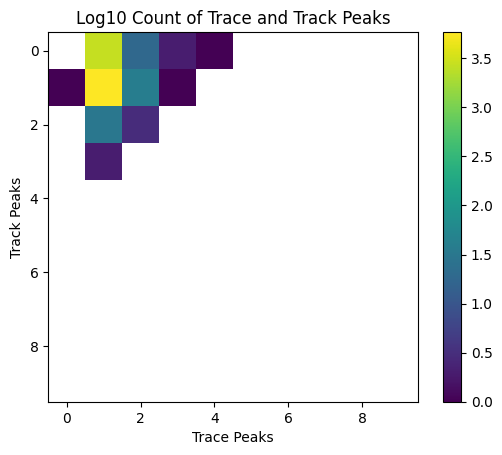

In [46]:
# grid plot of counts
plt.imshow(np.log10(counts))
plt.colorbar()
plt.xlabel('Trace Peaks')
plt.ylabel('Track Peaks')
plt.title('Log10 Count of Trace and Track Peaks');